In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Assumindo que df_select_clean é o seu DataFrame após a limpeza e pré-processamento
# Nota

# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/My Drive/datasets/steam/steam.zip", compression='zip', sep=',')


In [ ]:
# Configurando o Pandas para exibir todas as colunas
pd.set_option('display.max_columns', None)


# Funções

In [ ]:
# Função para separar gêneros

def cria_identificadores_genero(df:pd.DataFrame, col:str, sep:str = ',') -> pd.DataFrame:
    """
    Função que cria identificadores para jogos a partir de colunas contendo strings separadas por um delimitador comum
    """
    df = df.copy()

    generos = np.unique(
        df[col]
        .drop_duplicates()
        .str.cat(sep=sep)
        .split(sep)
    )

    for genero in generos:
        df[f'{genero}'.upper()] = (
            df[col].str.contains(genero, regex=True)
        )

    df = df.drop(col, axis=1)
    return df


# Função para detectar e plotar outliers
def detectar_plotar_outliers(coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[((df[coluna] < (Q1 - 3 * IQR)) | (df[coluna] > (Q3 + 3 * IQR)))]
    print(f"Outliers em '{coluna}':", outliers.shape[0])

    # Plot
    sns.boxplot(x=df[coluna])
    plt.title(f'Boxplot - {coluna}')
    plt.show()


# Função para remover outliers de uma coluna e adicioná-los ao DataFrame de outliers
def remover_adicionar_outliers(coluna, df_original, df_destino):
    Q1 = df_original[coluna].quantile(0.25)
    Q3 = df_original[coluna].quantile(0.75)
    IQR = Q3 - Q1

    # Condição para identificar outliers
    condicao = (df_original[coluna] < (Q1 - 3 * IQR)) | (df_original[coluna] > (Q3 + 3 * IQR))

    # Seleciona os outliers baseado na condição
    outliers_temp = df_original[condicao]

    # Converte colunas do tipo object com todos valores booleanos para bool
    bool_cols = outliers_temp.select_dtypes(include=['object']).columns
    for col in bool_cols:
        if outliers_temp[col].dropna().unique().tolist() == [True, False]:
            outliers_temp[col] = outliers_temp[col].astype(bool)

    # Adiciona os outliers ao DataFrame de destino
    df_destino = pd.concat([df_destino, outliers_temp], ignore_index=True)

    # Remove os outliers do DataFrame original
    df_original = df_original[~condicao]

    return df_original, df_destino


def plot_histograms(dataframe, columns):
    for col in columns:
        # Verificar se a coluna é numérica
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            plt.figure(figsize=(10, 6))
            dataframe[col].hist(bins=30)
            plt.title(f'Histograma da Coluna: {col}')
            plt.xlabel(col)
            plt.ylabel('Contagem')
            plt.show()



def contar_valores(dataframe, columns):
    for col in columns:
        print(f"Contagem de valores para a coluna: {col}")
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            # Para colunas numéricas, você pode querer agrupar os dados antes de contar, ou simplesmente contar valores únicos
            # Aqui está um exemplo simples de contar valores únicos diretamente
            print(dataframe[col].value_counts().sort_index())
        else:
            # Para colunas não numéricas, contando valores únicos diretamente
            print(dataframe[col].value_counts())
        print("\n---\n")



In [ ]:
df.head()


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Casual,Indie,Sports","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Action,Indie","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,"Action,Adventure,Indie,Strategy",NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","Adventure,Casual,Indie","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,NaN,0,50,8,NaN,17,0,This Game may contain content not appropriate ...,0,0,0,0,Unusual Games,Unusual Games,"Single-player,Steam Achievements","Adventure,Indie","Indie,Adventure,Nudity,Violent,Sexual Content,...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...


In [ ]:
df.shape

(85103, 39)

In [ ]:
df.columns

Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages', 'Full audio languages', 'Reviews',
       'Header image', 'Website', 'Support url', 'Support email', 'Windows',
       'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score',
       'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations',
       'Notes', 'Average playtime forever', 'Average playtime two weeks',
       'Median playtime forever', 'Median playtime two weeks', 'Developers',
       'Publishers', 'Categories', 'Genres', 'Tags', 'Screenshots', 'Movies'],
      dtype='object')

In [ ]:
# Descrição estatística das variáveis numéricas
df.describe()


,AppID,Peak CCU,Required age,Price,DLC count,Metacritic score,User score,Positive,Negative,Score rank,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks
count,8.510300e+04,85103.000000,85103.000000,85103.000000,85103.000000,85103.000000,85103.000000,8.510300e+04,85103.000000,44.000000,85103.000000,8.510300e+04,85103.000000,85103.000000,85103.000000,85103.000000
mean,1.355681e+06,134.872930,0.312774,7.193703,0.543412,3.348366,0.039822,9.585609e+02,159.772570,98.909091,19.859394,7.755176e+02,104.729681,10.680105,93.316029,11.467328
std,6.949952e+05,5403.548851,2.254721,12.362478,13.721223,15.421471,1.791013,2.435920e+04,4574.583903,0.857747,171.446874,1.789338e+04,1142.447517,188.840006,1510.732101,205.372944
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,97.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.723900e+05,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,98.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,1.331540e+06,0.000000,0.000000,4.490000,0.000000,0.000000,0.000000,7.000000e+00,2.000000,99.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,1.918415e+06,1.000000,0.000000,9.990000,0.000000,0.000000,0.000000,4.500000e+01,14.000000,100.000000,18.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,2.765800e+06,872138.000000,21.000000,999.980000,2366.000000,97.000000,100.000000,5.764420e+06,895978.000000,100.000000,9821.000000,3.441592e+06,145727.000000,19159.000000,208473.000000,19159.000000


# Contagem de Valores para Variáveis Categóricas
Vamos ver quantos jogos temos por categoria, gênero, desenvolvedora, etc.:

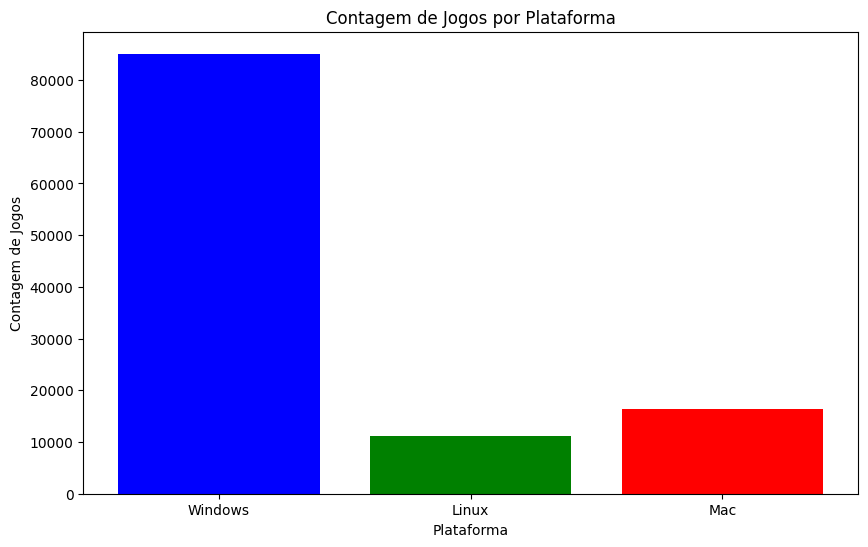

In [ ]:
# Contagem de jogos que suportam cada plataforma
contagem_windows = df['Windows'].sum()
contagem_linux = df['Linux'].sum()
contagem_mac = df['Mac'].sum()

# Preparando os dados para a plotagem
plataformas = ['Windows', 'Linux', 'Mac']
contagens = [contagem_windows, contagem_linux, contagem_mac]

# Plotando os dados
plt.figure(figsize=(10, 6))
plt.bar(plataformas, contagens, color=['blue', 'green', 'red'])
plt.title('Contagem de Jogos por Plataforma')
plt.xlabel('Plataforma')
plt.ylabel('Contagem de Jogos')
plt.show()

In [ ]:
# Calcular jogos que são para Mac e Windows, e Linux e Windows
mac_and_windows = df[(df['Mac'] == True) & (df['Windows'] == True)].shape[0]
linux_and_windows = df[(df['Linux'] == True) & (df['Windows'] == True)].shape[0]

# Calcular jogos exclusivos para Mac e Linux
mac_exclusivos = df[(df['Mac'] == True) & (df['Windows'] == False)].shape[0]
linux_exclusivos = df[(df['Linux'] == True) & (df['Windows'] == False)].shape[0]

# Calcular a porcentagem desses jogos em relação ao total de jogos Mac e Linux
porcentagem_mac_windows = (mac_and_windows / contagem_mac) * 100
porcentagem_linux_windows = (linux_and_windows / contagem_linux) * 100

# Calcular a porcentagem de jogos exclusivos para Mac e Linux
porcentagem_mac_exclusivos = (mac_exclusivos / contagem_mac) * 100
porcentagem_linux_exclusivos = (linux_exclusivos / contagem_linux) * 100

print(f"Jogos de Mac que também são para Windows: {mac_and_windows} ({porcentagem_mac_windows:.2f}%)")
print(f"Jogos de Linux que também são para Windows: {linux_and_windows} ({porcentagem_linux_windows:.2f}%)")
print(f"Jogos exclusivos para Mac: {mac_exclusivos} ({porcentagem_mac_exclusivos:.2f}%)")
print(f"Jogos exclusivos para Linux: {linux_exclusivos} ({porcentagem_linux_exclusivos:.2f}%)")


Jogos de Mac que também são para Windows: 16368 (99.85%)
Jogos de Linux que também são para Windows: 11190 (99.95%)
Jogos exclusivos para Mac: 25 (0.15%)
Jogos exclusivos para Linux: 6 (0.05%)


In [ ]:
# Contagem de valores para uma variável categórica, exemplo com 'Genres'
print(df['Genres'].value_counts())


Casual,Indie                                                                   4811
Action,Indie                                                                   4421
Action,Adventure,Indie                                                         3643
Adventure,Indie                                                                3110
Adventure,Casual,Indie                                                         2561
                                                                               ... 
Action,Adventure,Massively Multiplayer,Racing                                     1
Violent,Action,Adventure,Indie,Strategy,Early Access                              1
Adventure,Free to Play,Massively Multiplayer,RPG,Simulation,Sports,Strategy       1
Audio Production,Software Training,Utilities,Web Publishing                       1
Action,Casual,Indie,Simulation,Free to Play                                       1
Name: Genres, Length: 2471, dtype: int64


In [ ]:
# Identifica a quantidade de valores ausentes por coluna
df.isnull().sum()


AppID                             0
Name                              6
Release date                      0
Estimated owners                  0
Peak CCU                          0
Required age                      0
Price                             0
DLC count                         0
About the game                 3567
Supported languages               0
Full audio languages              0
Reviews                       75360
Header image                      0
Website                       45651
Support url                   43511
Support email                 13593
Windows                           0
Mac                               0
Linux                             0
Metacritic score                  0
Metacritic url                81191
User score                        0
Positive                          0
Negative                          0
Score rank                    85059
Achievements                      0
Recommendations                   0
Notes                       

In [ ]:
colunas_selecionadas = [
    'Estimated owners', 'Peak CCU',
    'Price', 'DLC count', 'Metacritic score', 'User score',
    'Positive', 'Negative', 'Score rank', 'Recommendations',
    'Average playtime forever', 'Average playtime two weeks',
    'Median playtime forever', 'Median playtime two weeks'
]

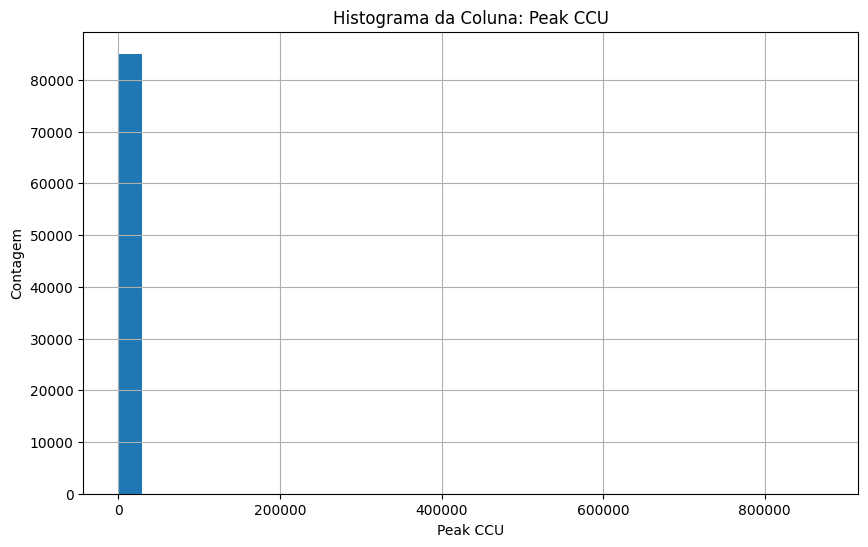

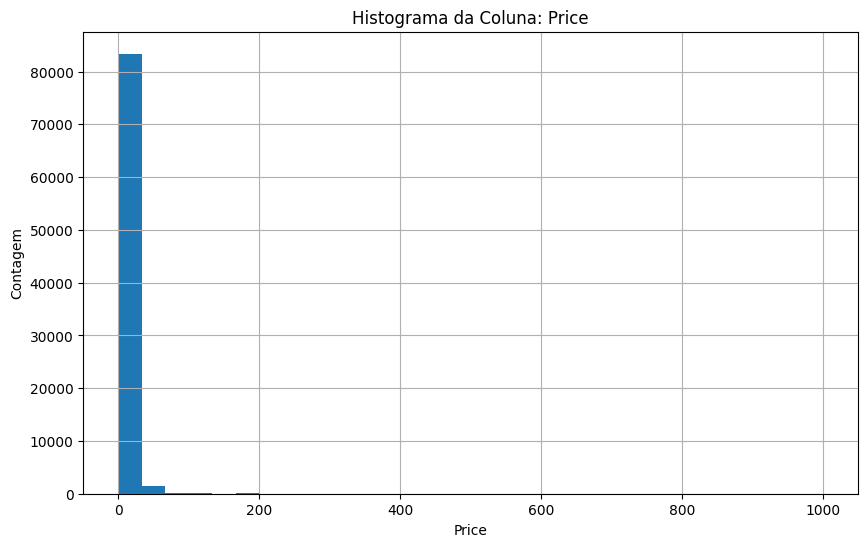

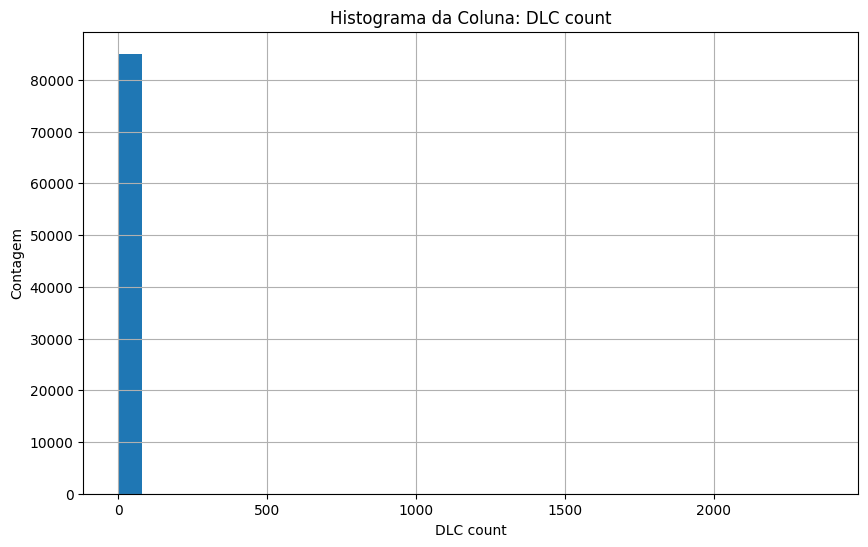

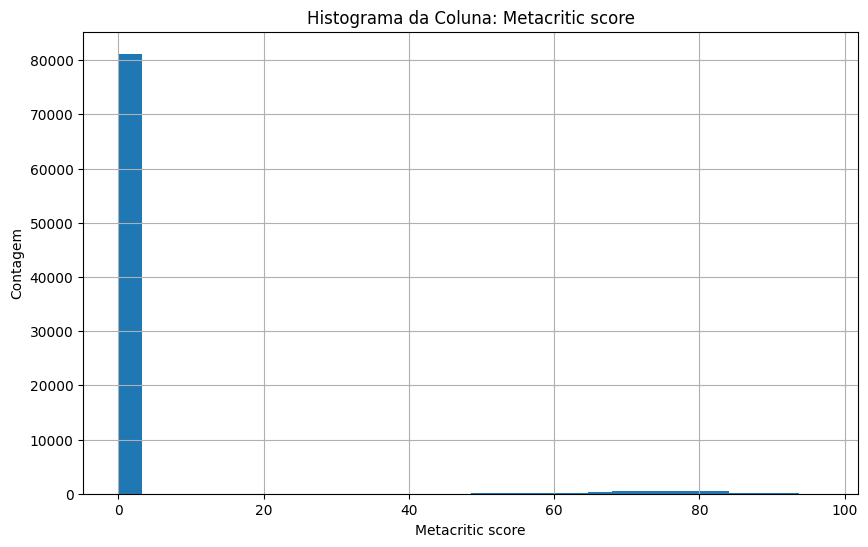

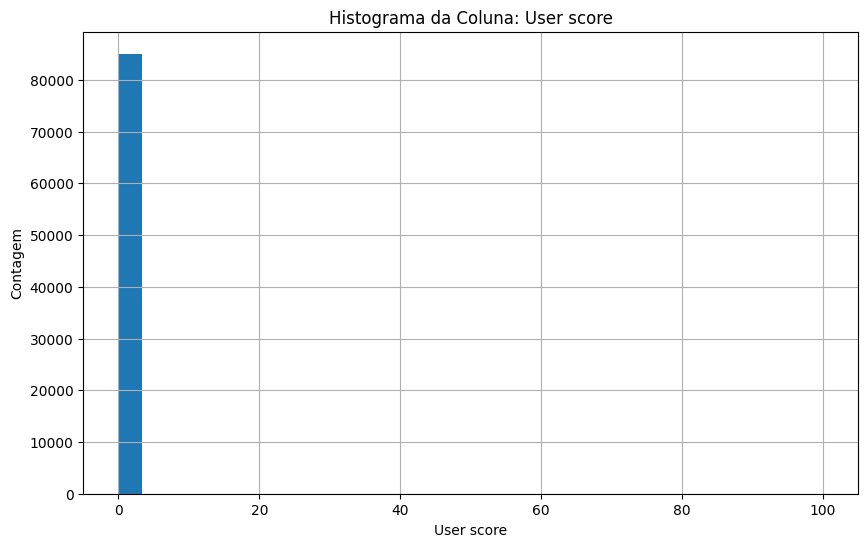

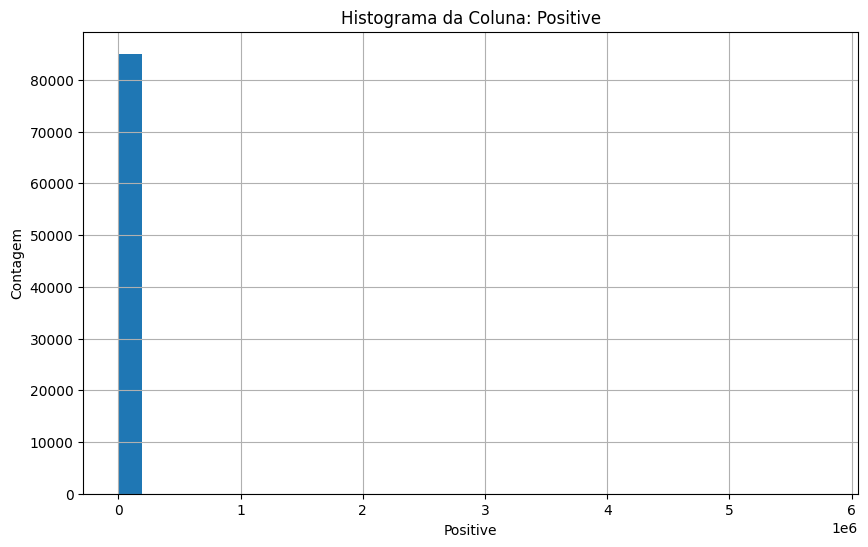

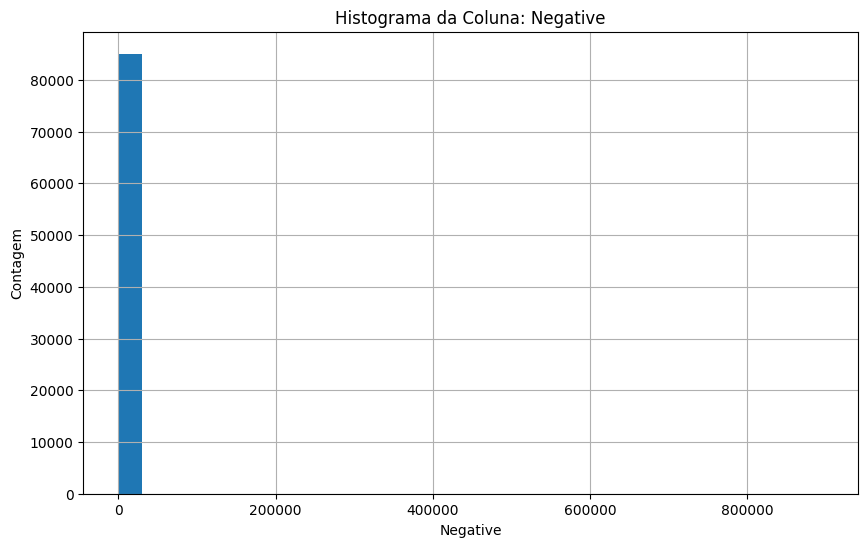

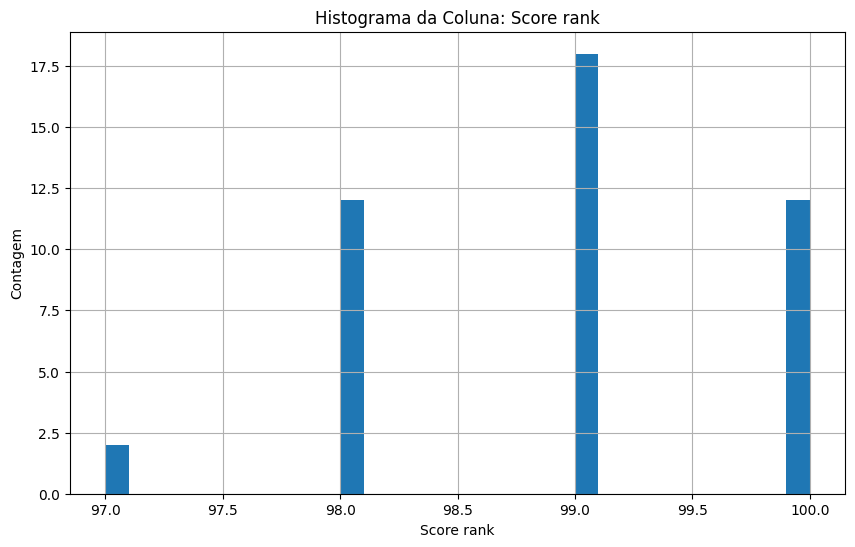

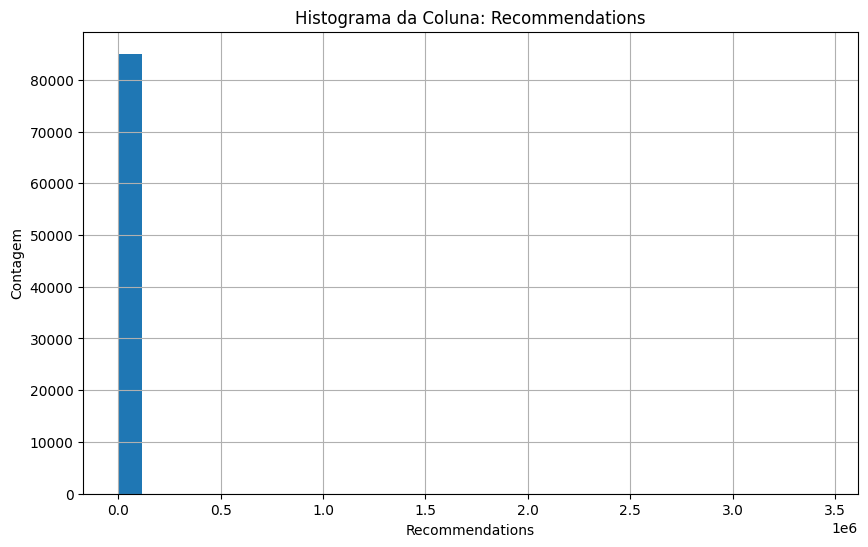

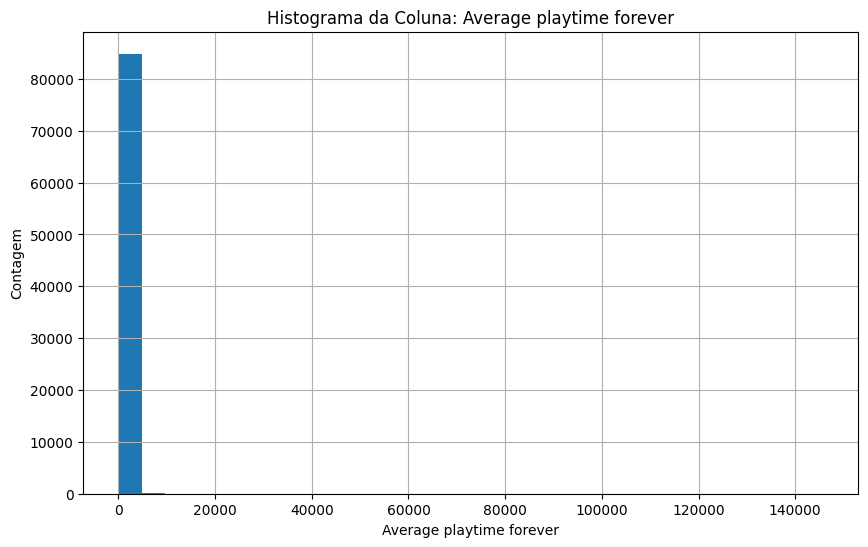

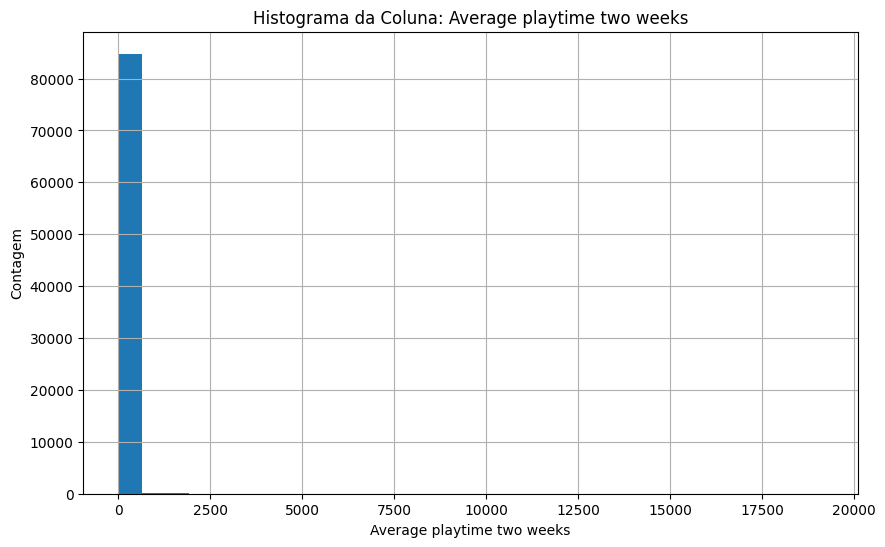

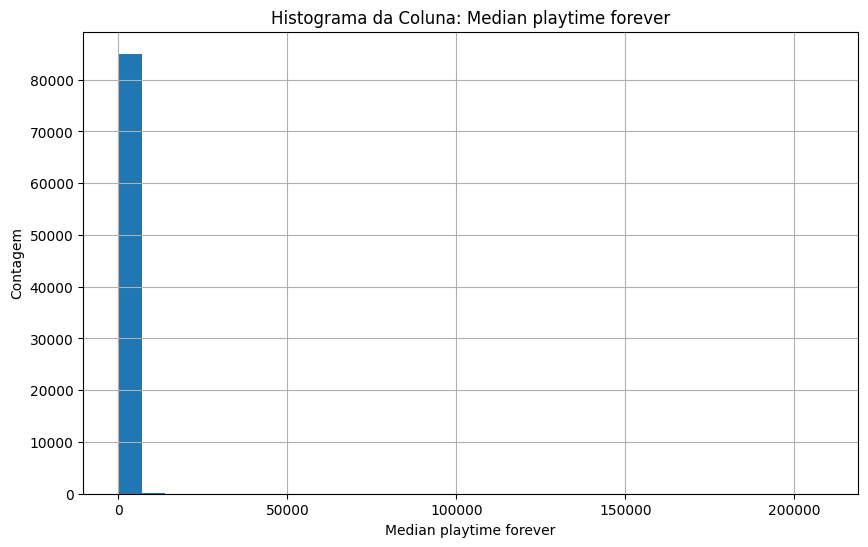

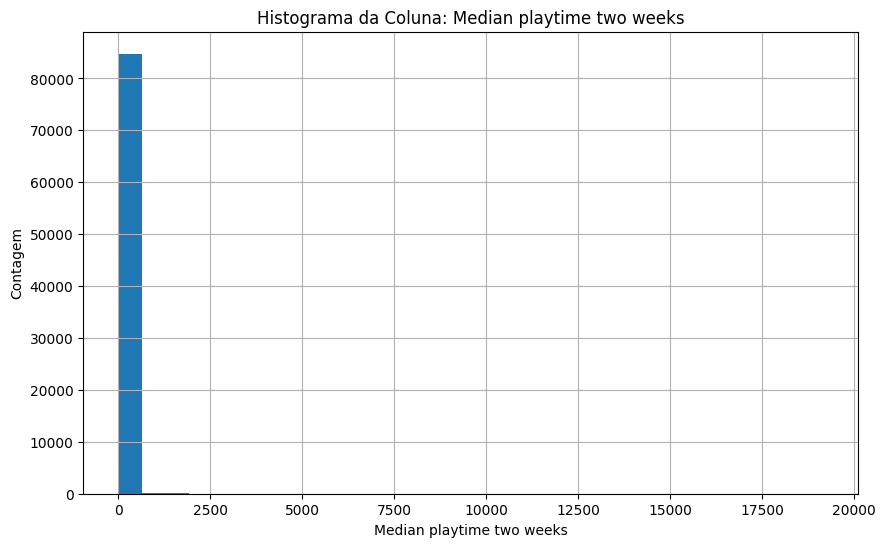

In [ ]:
plot_histograms(df, colunas_selecionadas)


In [ ]:
contar_valores(df, colunas_selecionadas)


Contagem de valores para a coluna: Estimated owners
0 - 20000                55285
0 - 0                    11504
20000 - 50000             7808
50000 - 100000            3886
100000 - 200000           2566
200000 - 500000           2142
500000 - 1000000           906
1000000 - 2000000          521
2000000 - 5000000          329
5000000 - 10000000          92
10000000 - 20000000         38
20000000 - 50000000         21
50000000 - 100000000         4
100000000 - 200000000        1
Name: Estimated owners, dtype: int64

---

Contagem de valores para a coluna: Peak CCU
0         62436
1          7087
2          2845
3          1596
4          1146
          ...  
287501        1
405191        1
558759        1
825215        1
872138        1
Name: Peak CCU, Length: 1445, dtype: int64

---

Contagem de valores para a coluna: Price
0.00      16461
0.29          1
0.35          1
0.37          1
0.44          1
          ...  
249.00        1
269.99        1
299.90        1
999.00        1
9

<ipython-input-34-40246405727e>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, fmt=".2f")


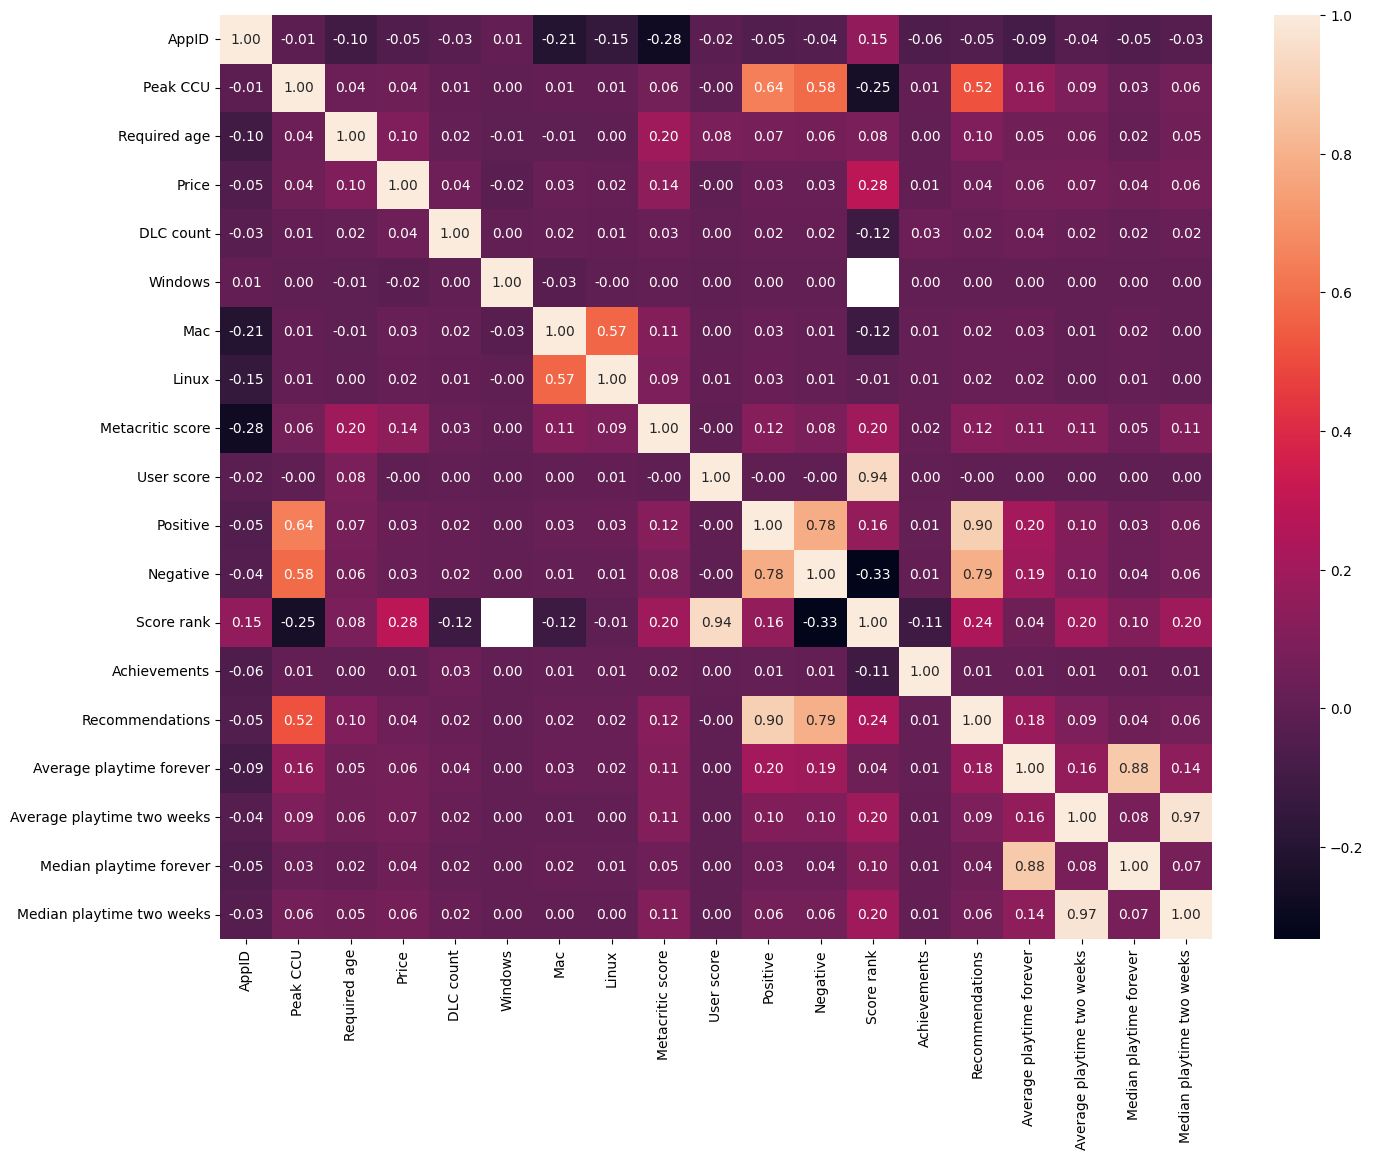

In [ ]:
# Mapa de calor das correlações
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.show()

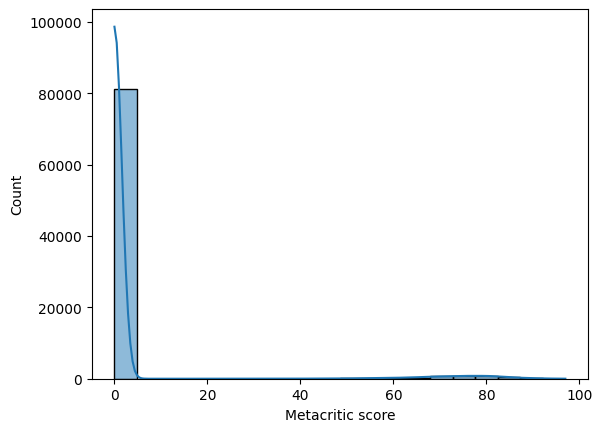

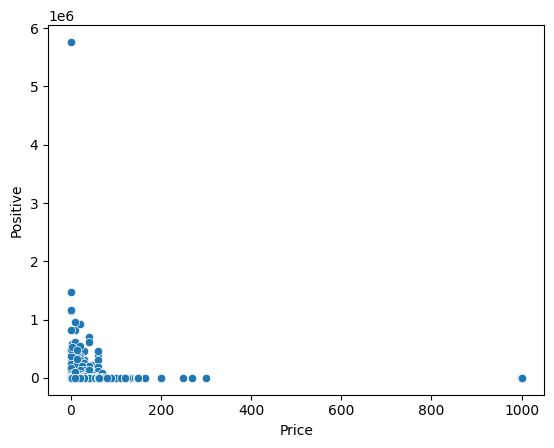

In [ ]:
# Histograma da 'Metacritic score'
sns.histplot(data=df, x='Metacritic score', bins=20, kde=True)
plt.show()

# Scatter plot de 'Price' vs. 'Positive'
sns.scatterplot(data=df, x='Price', y='Positive')
plt.show()


In [ ]:
df = cria_identificadores_genero(df=df, col='Genres', sep=',')

In [ ]:
df.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Tags,Screenshots,Movies,360 VIDEO,ACCOUNTING,ACTION,ADVENTURE,ANIMATION & MODELING,AUDIO PRODUCTION,CASUAL,DESIGN & ILLUSTRATION,DOCUMENTARY,EARLY ACCESS,EDUCATION,EPISODIC,FREE TO PLAY,GAME DEVELOPMENT,GORE,INDIE,MASSIVELY MULTIPLAYER,MOVIE,NUDITY,PHOTO EDITING,RPG,RACING,SEXUAL CONTENT,SHORT,SIMULATION,SOFTWARE TRAINING,SPORTS,STRATEGY,TUTORIAL,UTILITIES,VIDEO PRODUCTION,VIOLENT,WEB PUBLISHING
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Single-player,Multi-player,Steam Achievements,...","Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Single-player,Steam Achievements,Full controll...","Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,Single-player,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,1355720,Henosis™,"Jul 23, 2020",0 - 20000,0,0,5.99,0,HENOSIS™ is a mysterious 2D Platform Puzzler w...,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://henosisgame.com/,https://henosisgame.com/,info@henosisgame.com,True,True,True,0,NaN,0,3,0,NaN,0,0,NaN,0,0,0,0,Odd Critter Games,Odd Critter Games,"Single-player,Full controller support","2D Platformer,Atmospheric,Surreal,Mystery,Puzz...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1139950,Two Weeks in Painland,"Feb 3, 2020",0 - 20000,0,0,0.00,0,ABOUT THE GAME Play as a hacker who has arrang...,"['English', 'Spanish - Spain']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.unusual-games.com/home/,https://www.unusual-games.com/contact/,welistentoyou@unusual-games.com,True,True,False,0,N

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85103 entries, 0 to 85102
Data columns (total 71 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       85103 non-null  int64  
 1   Name                        85097 non-null  object 
 2   Release date                85103 non-null  object 
 3   Estimated owners            85103 non-null  object 
 4   Peak CCU                    85103 non-null  int64  
 5   Required age                85103 non-null  int64  
 6   Price                       85103 non-null  float64
 7   DLC count                   85103 non-null  int64  
 8   About the game              81536 non-null  object 
 9   Supported languages         85103 non-null  object 
 10  Full audio languages        85103 non-null  object 
 11  Reviews                     9743 non-null   object 
 12  Header image                85103 non-null  object 
 13  Website                     394

In [ ]:
df.describe()

,AppID,Peak CCU,Required age,Price,DLC count,Metacritic score,User score,Positive,Negative,Score rank,Achievements,Recommendations,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks
count,8.510300e+04,85103.000000,85103.000000,85103.000000,85103.000000,85103.000000,85103.000000,8.510300e+04,85103.000000,44.000000,85103.000000,8.510300e+04,85103.000000,85103.000000,85103.000000,85103.000000
mean,1.355681e+06,134.872930,0.312774,7.193703,0.543412,3.348366,0.039822,9.585609e+02,159.772570,98.909091,19.859394,7.755176e+02,104.729681,10.680105,93.316029,11.467328
std,6.949952e+05,5403.548851,2.254721,12.362478,13.721223,15.421471,1.791013,2.435920e+04,4574.583903,0.857747,171.446874,1.789338e+04,1142.447517,188.840006,1510.732101,205.372944
min,1.000000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,97.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.723900e+05,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,98.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
50%,1.331540e+06,0.000000,0.000000,4.490000,0.000000,0.000000,0.000000,7.000000e+00,2.000000,99.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
75%,1.918415e+06,1.000000,0.000000,9.990000,0.000000,0.000000,0.000000,4.500000e+01,14.000000,100.000000,18.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
max,2.765800e+06,872138.000000,21.000000,999.980000,2366.000000,97.000000,100.000000,5.764420e+06,895978.000000,100.000000,9821.000000,3.441592e+06,145727.000000,19159.000000,208473.000000,19159.000000


In [ ]:
df = cria_identificadores_genero(df=df, col='Categories', sep=',')

<ipython-input-22-daa4ffafd77e>:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[col].str.contains(genero, regex=True)


In [ ]:
df.head()

,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Tags,Screenshots,Movies,360 VIDEO,ACCOUNTING,ACTION,ADVENTURE,ANIMATION & MODELING,AUDIO PRODUCTION,CASUAL,DESIGN & ILLUSTRATION,DOCUMENTARY,EARLY ACCESS,EDUCATION,EPISODIC,FREE TO PLAY,GAME DEVELOPMENT,GORE,INDIE,MASSIVELY MULTIPLAYER,MOVIE,NUDITY,PHOTO EDITING,RPG,RACING,SEXUAL CONTENT,SHORT,SIMULATION,SOFTWARE TRAINING,SPORTS,STRATEGY,TUTORIAL,UTILITIES,VIDEO PRODUCTION,VIOLENT,WEB PUBLISHING,CAPTIONS AVAILABLE,CO-OP,COMMENTARY AVAILABLE,CROSS-PLATFORM MULTIPLAYER,FULL CONTROLLER SUPPORT,HDR AVAILABLE,IN-APP PURCHASES,INCLUDES SOURCE SDK,INCLUDES LEVEL EDITOR,LAN CO-OP,LAN PVP,MMO,MODS,MODS (REQUIRE HL2),MULTI-PLAYER,ONLINE CO-OP,ONLINE PVP,PARTIAL CONTROLLER SUPPORT,PVP,REMOTE PLAY TOGETHER,REMOTE PLAY ON PHONE,REMOTE PLAY ON TV,REMOTE PLAY ON TABLET,SHARED/SPLIT SCREEN,SHARED/SPLIT SCREEN CO-OP,SHARED/SPLIT SCREEN PVP,SINGLE-PLAYER,STATS,STEAM ACHIEVEMENTS,STEAM CLOUD,STEAM LEADERBOARDS,STEAM TRADING CARDS,STEAM TURN NOTIFICATIONS,STEAM WORKSHOP,STEAMVR COLLECTIBLES,TRACKED CONTROLLER SUPPORT,TRACKED MOTION CONTROLLER SUPPORT,VR ONLY,VR SUPPORT,VR SUPPORTED,VALVE ANTI-CHEAT ENABLED
0,20200,Galactic Bowling,"Oct 21, 2008",0 - 20000,0,0,19.99,0,Galactic Bowling is an exaggerated and stylize...,['English'],[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://www.galacticbowling.net,NaN,NaN,True,False,False,0,NaN,0,6,11,NaN,30,0,NaN,0,0,0,0,Perpetual FX Creative,Perpetual FX Creative,"Indie,Casual,Sports,Bowling",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,655370,Train Bandit,"Oct 12, 2017",0 - 20000,0,0,0.99,0,THE LAW!! Looks to be a showdown atop a train....,"['English', 'French', 'Italian', 'German', 'Sp...",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://trainbandit.com,NaN,support@rustymoyher.com,True,True,False,0,NaN,0,53,5,NaN,12,0,NaN,0,0,0,0,Rusty Moyher,Wild Rooster,"Indie,Action,Pixel Graphics,2D,Retro,Arcade,Sc...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False
2,1732930,Jolt Project,"Nov 17, 2021",0 - 20000,0,0,4.99,0,Jolt Project: The army now has a new robotics ...,"['English', 'Portuguese - Brazil']",[],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,ramoncampiaof31@gmail.com,True,False,False,0,NaN,0,0,0,NaN,0,0,NaN,0,0,0,0,Campião Games,Campião Games,NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,F

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85103 entries, 0 to 85102
Columns: 111 entries, AppID to VALVE ANTI-CHEAT ENABLED
dtypes: bool(3), float64(2), int64(14), object(92)
memory usage: 70.4+ MB


In [ ]:
stop

NameError: name 'stop' is not defined

# Outliers

In [ ]:
df['Estimated owners'] = df['Estimated owners'].str.split('-').str[0].str.replace('k', '000').astype(int)


Outliers em 'Price': 1481


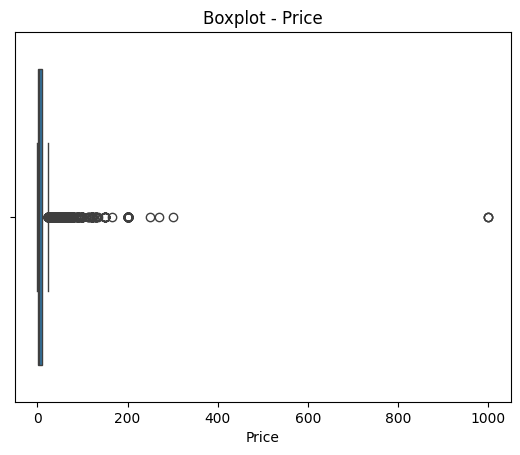

Outliers em 'Peak CCU': 9993


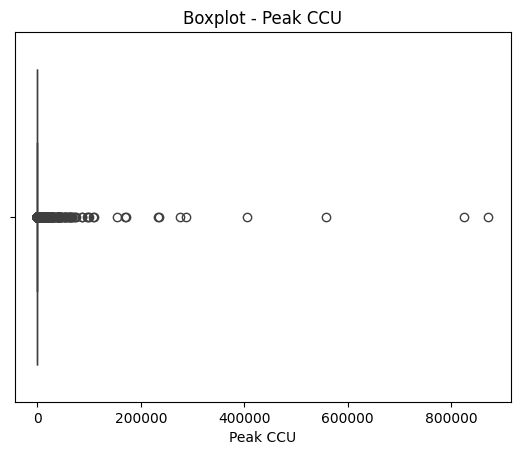

Outliers em 'Estimated owners': 18314


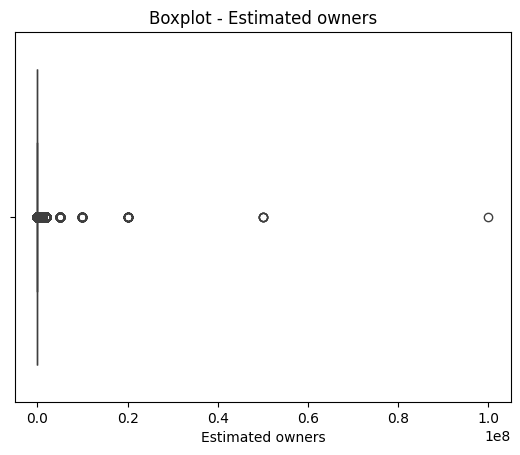

Outliers em 'Positive': 11658


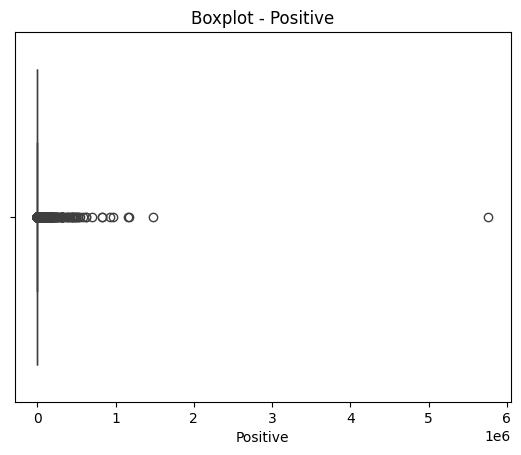

Outliers em 'Negative': 10806


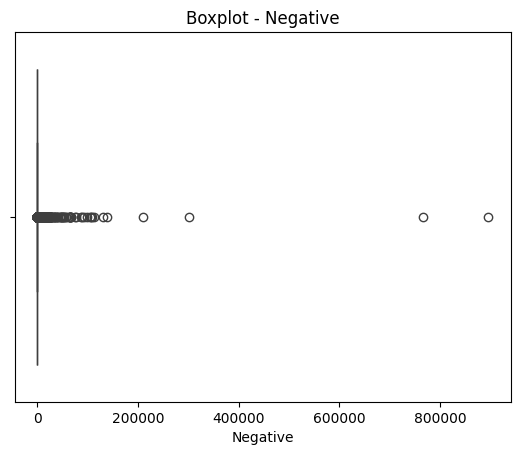

Outliers em 'Achievements': 2460


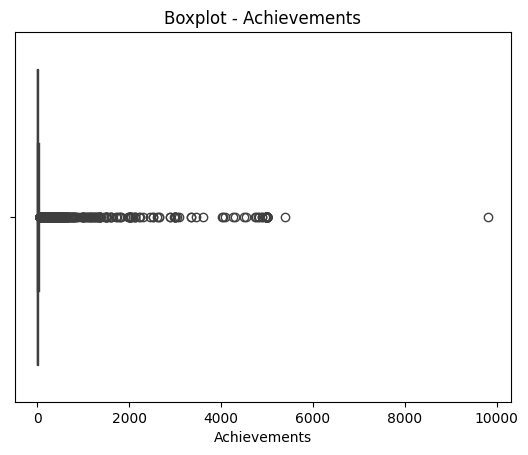

Outliers em 'Average playtime forever': 14911


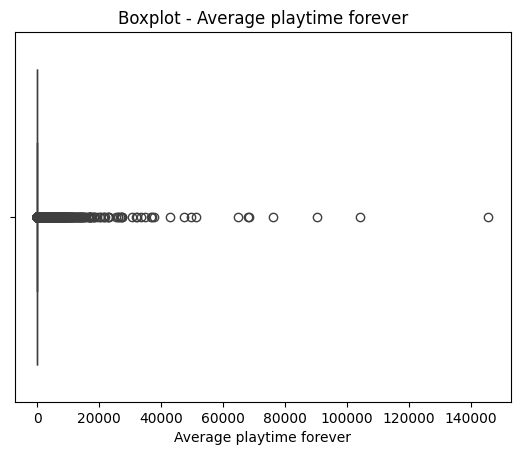

In [ ]:
# Lista de colunas para analisar outliers
colunas_para_analise = ['Price', 'Peak CCU', 'Estimated owners', 'Positive', 'Negative', 'Achievements', 'Average playtime forever']

# Itera sobre a lista de colunas, detectando e plotando outliers
for coluna in colunas_para_analise:
    detectar_plotar_outliers(coluna)

In [ ]:
# Identificação de outliers na coluna 'Price'
Q1_price = df['Price'].quantile(0.25)
Q3_price = df['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
outliers_price = df[((df['Price'] < (Q1_price - 3 * IQR_price)) | (df['Price'] > (Q3_price + 3 * IQR_price)))]

# Ordenando os outliers pelo 'Price' para talvez ver os mais caros no topo
outliers_price_sorted = outliers_price.sort_values(by='Price', ascending=False)

# Selecionando detalhes específicos para exibir
outliers_details = outliers_price_sorted[['Name', 'Price', 'Estimated owners', 'Positive', 'Negative', 'Average playtime forever']].head(10)

print("Detalhes de alguns outliers na coluna 'Price':")
outliers_details


Detalhes de alguns outliers na coluna 'Price':


,Name,Price,Estimated owners,Positive,Negative,Average playtime forever
82971,The Leverage Game Business Edition,999.98,0,0,0,0
81901,The Leverage Game,999.98,0,0,0,0
26936,Ascent Free-Roaming VR Experience,999.00,0,6,0,0
57689,Aartform Curvy 3D 3.0,299.90,0,32,13,150
32110,Houdini Indie,269.99,0,141,7,0
12150,VEGAS 19 Edit - Steam Edition,249.00,0,20,8,0
15559,The Island of Dr. Yepstein,199.99,0,9,5,0
83373,TNMverse VIP,199.99,0,0,0,0
14486,VRemedies - Radiotherapy Procedure Experience,199.99,0,0,0,0
64596,Rush Red & Blue,199.99,0,0,0,0


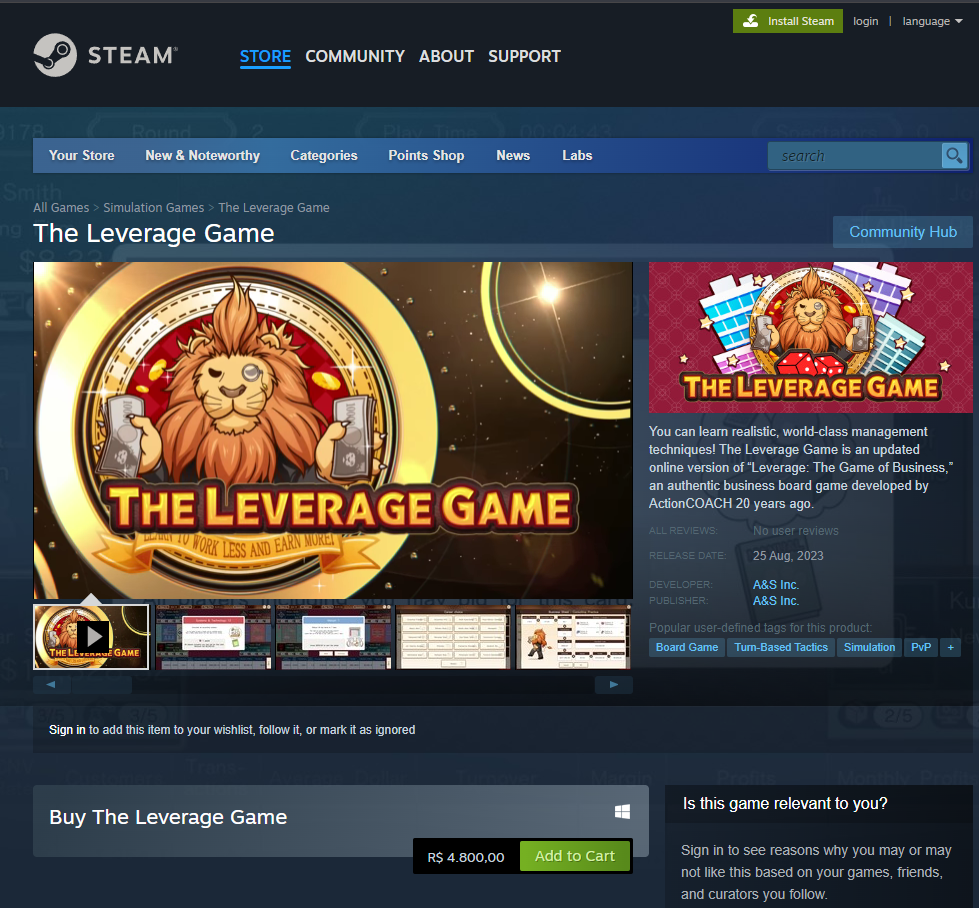

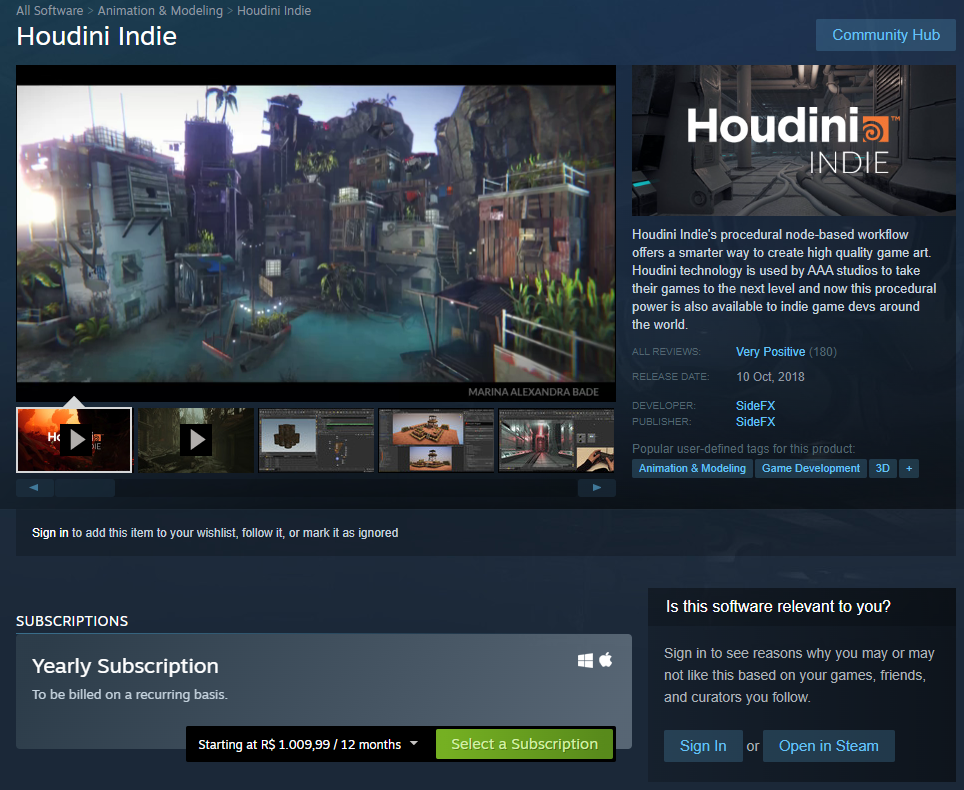

In [ ]:
# Cria um novo DataFrame vazio para armazenar os outliers
df_outliers = pd.DataFrame(columns=df.columns)


In [ ]:
# Itera sobre a lista de colunas, removendo outliers
for coluna in colunas_para_analise:
    df, df_outliers = remover_adicionar_outliers(coluna, df, df_outliers)



<ipython-input-22-daa4ffafd77e>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_temp[col] = outliers_temp[col].astype(bool)
<ipython-input-22-daa4ffafd77e>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_temp[col] = outliers_temp[col].astype(bool)
<ipython-input-22-daa4ffafd77e>:58: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_destino = pd.concat([df_dest

In [ ]:
# Verifica o resultado
print("DataFrame original após remoção dos outliers:")
df.info()


DataFrame original após remoção dos outliers:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 52013 entries, 0 to 85102
Columns: 111 entries, AppID to VALVE ANTI-CHEAT ENABLED
dtypes: bool(3), float64(2), int64(15), object(91)
memory usage: 43.4+ MB


In [ ]:
print("DataFrame de outliers:")
df_outliers.info()

DataFrame de outliers:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33090 entries, 0 to 33089
Columns: 111 entries, AppID to VALVE ANTI-CHEAT ENABLED
dtypes: float64(2), object(109)
memory usage: 28.0+ MB


In [ ]:
# Mostrar todas as colunas do DataFrame
print(df.columns)

# Para uma visualização como lista
lista_de_colunas = df.columns.tolist()
print(lista_de_colunas)


Index(['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU',
       'Required age', 'Price', 'DLC count', 'About the game',
       'Supported languages',
       ...
       'STEAM TRADING CARDS', 'STEAM TURN NOTIFICATIONS', 'STEAM WORKSHOP',
       'STEAMVR COLLECTIBLES', 'TRACKED CONTROLLER SUPPORT',
       'TRACKED MOTION CONTROLLER SUPPORT', 'VR ONLY', 'VR SUPPORT',
       'VR SUPPORTED', 'VALVE ANTI-CHEAT ENABLED'],
      dtype='object', length=111)
['AppID', 'Name', 'Release date', 'Estimated owners', 'Peak CCU', 'Required age', 'Price', 'DLC count', 'About the game', 'Supported languages', 'Full audio languages', 'Reviews', 'Header image', 'Website', 'Support url', 'Support email', 'Windows', 'Mac', 'Linux', 'Metacritic score', 'Metacritic url', 'User score', 'Positive', 'Negative', 'Score rank', 'Achievements', 'Recommendations', 'Notes', 'Average playtime forever', 'Average playtime two weeks', 'Median playtime forever', 'Median playtime two weeks', 'Developers', 'Pub

In [ ]:
selected_columns = ['AppID', 'Name',
                    'Price', '360 VIDEO', 'ACCOUNTING', 'ACTION',
                    'ADVENTURE', 'ANIMATION & MODELING', 'AUDIO PRODUCTION', 'CASUAL', 'DESIGN & ILLUSTRATION',
                    'DOCUMENTARY', 'EARLY ACCESS', 'EDUCATION', 'EPISODIC', 'FREE TO PLAY',
                    'GAME DEVELOPMENT', 'GORE', 'INDIE', 'MASSIVELY MULTIPLAYER', 'MOVIE', 'NUDITY',
                    'PHOTO EDITING', 'RPG', 'RACING', 'SEXUAL CONTENT', 'SHORT', 'SIMULATION',
                    'SOFTWARE TRAINING', 'SPORTS', 'STRATEGY', 'TUTORIAL', 'UTILITIES', 'VIDEO PRODUCTION',
                    'VIOLENT', 'WEB PUBLISHING', 'CAPTIONS AVAILABLE', 'CO-OP', 'COMMENTARY AVAILABLE',
                    'CROSS-PLATFORM MULTIPLAYER', 'FULL CONTROLLER SUPPORT', 'HDR AVAILABLE', 'IN-APP PURCHASES',
                    'INCLUDES SOURCE SDK', 'INCLUDES LEVEL EDITOR', 'LAN CO-OP', 'LAN PVP', 'MMO', 'MODS',
                    'MODS (REQUIRE HL2)', 'MULTI-PLAYER', 'ONLINE CO-OP', 'ONLINE PVP', 'PARTIAL CONTROLLER SUPPORT',
                    'PVP', 'REMOTE PLAY TOGETHER', 'REMOTE PLAY ON PHONE', 'REMOTE PLAY ON TV', 'REMOTE PLAY ON TABLET',
                    'SHARED/SPLIT SCREEN', 'SHARED/SPLIT SCREEN CO-OP', 'SHARED/SPLIT SCREEN PVP', 'SINGLE-PLAYER', 'STATS',
                    'STEAM ACHIEVEMENTS', 'STEAM CLOUD', 'STEAM LEADERBOARDS', 'STEAM TRADING CARDS',
                    'STEAM TURN NOTIFICATIONS', 'STEAM WORKSHOP', 'STEAMVR COLLECTIBLES', 'TRACKED CONTROLLER SUPPORT',
                    'TRACKED MOTION CONTROLLER SUPPORT', 'VR ONLY', 'VR SUPPORT', 'VR SUPPORTED', 'VALVE ANTI-CHEAT ENABLED']
df_select = df[selected_columns]
df_select.head(20)


,AppID,Name,Price,360 VIDEO,ACCOUNTING,ACTION,ADVENTURE,ANIMATION & MODELING,AUDIO PRODUCTION,CASUAL,DESIGN & ILLUSTRATION,DOCUMENTARY,EARLY ACCESS,EDUCATION,EPISODIC,FREE TO PLAY,GAME DEVELOPMENT,GORE,INDIE,MASSIVELY MULTIPLAYER,MOVIE,NUDITY,PHOTO EDITING,RPG,RACING,SEXUAL CONTENT,SHORT,SIMULATION,SOFTWARE TRAINING,SPORTS,STRATEGY,TUTORIAL,UTILITIES,VIDEO PRODUCTION,VIOLENT,WEB PUBLISHING,CAPTIONS AVAILABLE,CO-OP,COMMENTARY AVAILABLE,CROSS-PLATFORM MULTIPLAYER,FULL CONTROLLER SUPPORT,HDR AVAILABLE,IN-APP PURCHASES,INCLUDES SOURCE SDK,INCLUDES LEVEL EDITOR,LAN CO-OP,LAN PVP,MMO,MODS,MODS (REQUIRE HL2),MULTI-PLAYER,ONLINE CO-OP,ONLINE PVP,PARTIAL CONTROLLER SUPPORT,PVP,REMOTE PLAY TOGETHER,REMOTE PLAY ON PHONE,REMOTE PLAY ON TV,REMOTE PLAY ON TABLET,SHARED/SPLIT SCREEN,SHARED/SPLIT SCREEN CO-OP,SHARED/SPLIT SCREEN PVP,SINGLE-PLAYER,STATS,STEAM ACHIEVEMENTS,STEAM CLOUD,STEAM LEADERBOARDS,STEAM TRADING CARDS,STEAM TURN NOTIFICATIONS,STEAM WORKSHOP,STEAMVR COLLECTIBLES,TRACKED CONTROLLER SUPPORT,TRACKED MOTION CONTROLLER SUPPORT,VR ONLY,VR SUPPORT,VR SUPPORTED,VALVE ANTI-CHEAT ENABLED
0,20200,Galactic Bowling,19.99,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,655370,Train Bandit,0.99,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False
2,1732930,Jolt Project,4.99,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1355720,Henosis™,5.99,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1139950,Two Weeks in Painland,0.00,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
7,1968760,Legend of Rome - The Wrath of Mars,9.99,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False
12,1620060,Clockwork Dungeon,1.99,False,False,False,False,False,False,True

# ***************CONFERIR NULOS

In [ ]:
# Create a new clean DataFrame without dropping rows
df_select_clean = df_select.copy()  # Avoid view-copy issues

# Choose a suitable missing value handling strategy:
# - Imputation (e.g., filling with mean, median, or mode)
# - Removing rows/columns with too many missing values
# - Consider domain knowledge and data characteristics to decide.

# Example: Impute missing values using the median

df_select_clean.fillna(df_select_clean.median(), inplace=True)

# Use the clean DataFrame and the correct column name
encoder = LabelEncoder()
df_select_clean['Name'] = encoder.fit_transform(df_select_clean['Name'])
df_select_clean.head()


<ipython-input-59-5739732db1af>:11: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_select_clean.fillna(df_select_clean.median(), inplace=True)


,AppID,Name,Price,360 VIDEO,ACCOUNTING,ACTION,ADVENTURE,ANIMATION & MODELING,AUDIO PRODUCTION,CASUAL,DESIGN & ILLUSTRATION,DOCUMENTARY,EARLY ACCESS,EDUCATION,EPISODIC,FREE TO PLAY,GAME DEVELOPMENT,GORE,INDIE,MASSIVELY MULTIPLAYER,MOVIE,NUDITY,PHOTO EDITING,RPG,RACING,SEXUAL CONTENT,SHORT,SIMULATION,SOFTWARE TRAINING,SPORTS,STRATEGY,TUTORIAL,UTILITIES,VIDEO PRODUCTION,VIOLENT,WEB PUBLISHING,CAPTIONS AVAILABLE,CO-OP,COMMENTARY AVAILABLE,CROSS-PLATFORM MULTIPLAYER,FULL CONTROLLER SUPPORT,HDR AVAILABLE,IN-APP PURCHASES,INCLUDES SOURCE SDK,INCLUDES LEVEL EDITOR,LAN CO-OP,LAN PVP,MMO,MODS,MODS (REQUIRE HL2),MULTI-PLAYER,ONLINE CO-OP,ONLINE PVP,PARTIAL CONTROLLER SUPPORT,PVP,REMOTE PLAY TOGETHER,REMOTE PLAY ON PHONE,REMOTE PLAY ON TV,REMOTE PLAY ON TABLET,SHARED/SPLIT SCREEN,SHARED/SPLIT SCREEN CO-OP,SHARED/SPLIT SCREEN PVP,SINGLE-PLAYER,STATS,STEAM ACHIEVEMENTS,STEAM CLOUD,STEAM LEADERBOARDS,STEAM TRADING CARDS,STEAM TURN NOTIFICATIONS,STEAM WORKSHOP,STEAMVR COLLECTIBLES,TRACKED CONTROLLER SUPPORT,TRACKED MOTION CONTROLLER SUPPORT,VR ONLY,VR SUPPORT,VR SUPPORTED,VALVE ANTI-CHEAT ENABLED
0,20200,16600,19.99,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,655370,44948,0.99,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,False,False,False,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False
2,1732930,21919,4.99,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,1355720,19032,5.99,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,1139950,45516,0.00,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Divisão do conjunto de dados em treinamento e teste
train_data, test_data = train_test_split(df_select_clean, test_size=0.2, random_state=42)


# Treinar o modelo de recomendação (KNN)
k = 5  # Número de vizinhos
knn_model = NearestNeighbors(n_neighbors=k, metric='cosine')
# Ajuste o modelo apenas com colunas numéricas, exceto 'AppID' que é o identificador único
X_train = train_data.drop(columns=['AppID', 'Name'])  # Presume que todas as outras colunas são numéricas
knn_model.fit(X_train)




NearestNeighbors(metric='cosine')

In [ ]:
# Calcular o RMSE baseado em 'Average playtime forever'
X_test = test_data.drop(columns=['AppID', 'Name'])
# Aqui, usaremos uma abordagem simplificada, assumindo que queremos comparar as recomendações com os próprios jogos testados
# Isto é apenas para ilustrar o cálculo do RMSE; ajuste conforme necessário para o seu caso de uso específico
distances, indices = knn_model.kneighbors(X_test, return_distance=True)
# predicted_playtime = [train_data.iloc[indices[i]]['Average playtime forever'].mean() for i in range(len(test_data))]
# actual_playtime = test_data['Average playtime forever'].values


In [ ]:
# Cálculo do RMSE
rmse = mean_squared_error(actual_playtime, predicted_playtime, squared=False)
print("RMSE:", rmse)



In [ ]:
# Exemplo de recomendação com jogos diferentes a cada execução
for i in range(5):
    # Selecionar um jogo aleatório do conjunto de testes sem especificar random_state
    example_game = test_data.sample(n=1)
    example_game_features = example_game.drop(columns=['AppID', 'Name'])

    # Realizar a recomendação para o jogo selecionado
    distances, indices = knn_model.kneighbors(example_game_features, n_neighbors=10, return_distance=True)

    # Recuperar os IDs dos jogos recomendados
    recommended_ids = train_data.iloc[indices[0]]['AppID']

    # Recuperar os nomes dos jogos recomendados usando os IDs
    recommended_games = df[df['AppID'].isin(recommended_ids)]

    # Exibindo o nome do jogo original e os nomes dos jogos recomendados com suas respectivas distâncias
    original_game_name = df[df['AppID'] == example_game['AppID'].values[0]]['Name'].values[0]
    print(f"Jogo Original: {original_game_name}")
    print("Jogos Recomendados e Distâncias:")
    for j, (name, distance) in enumerate(zip(recommended_games['Name'], distances[0])):
        print(f"{j+1}: {name} - Distância: {distance}")
    print("\n---\n")


Jogo Original: Street of Sanctuary VR
Jogos Recomendados e Distâncias:
1: Razed Earth - Distância: 0.028270124664779184
2: UTLL - Distância: 0.03791032791961446
3: MannaWars - Distância: 0.054598314504505474
4: Hell Knights - Distância: 0.055741049380995666
5: GunKour - Distância: 0.055741049380995666
6: Pillars Of Protection - Distância: 0.059624465414691574
7: Futr8 - Distância: 0.06646151937271327
8: GUNWATCH: Conflict Survival - Distância: 0.07577287230479901
9: Append - Distância: 0.0810065709573975
10: The Cannon Fighters - Distância: 0.0818252244504527

---

Jogo Original: Gum Ball Run
Jogos Recomendados e Distâncias:
1: UAL: Universal AIM League - Distância: 0.08712907082472299
2: JumpStream - Distância: 0.17841616374225078
3: NRG - Distância: 0.18350341907227397
4: DEATHVERSE: LET IT DIE - Distância: 0.18350341907227397
5: Car War Legends - Distância: 0.18350341907227397
6: World Boss - Distância: 0.20528058576097374
7: MOBILE SUIT GUNDAM BATTLE OPERATION 2 - Distância: 0.2166

In [ ]:
# Supondo que você já realizou a recomendação para um jogo específico
# Vamos pegar o primeiro exemplo após executar o loop anterior uma vez

# Selecionar um jogo aleatório do conjunto de testes sem especificar random_state
example_game = test_data.sample(n=1)
example_game_features = example_game.drop(columns=['AppID', 'Name'])

# Realizar a recomendação para o jogo selecionado
distances, indices = knn_model.kneighbors(example_game_features, n_neighbors=10, return_distance=True)

# Recuperar os IDs dos jogos recomendados
recommended_ids = train_data.iloc[indices[0]]['AppID']

# Criar um DataFrame para o jogo original
original_game_df = df[df['AppID'] == example_game['AppID'].values[0]]

# Criar um DataFrame para os jogos recomendados
recommended_games_df = df[df['AppID'].isin(recommended_ids)]

# Juntar o jogo original com os recomendados
comparison_df = pd.concat([original_game_df, recommended_games_df])

# Mostrar o DataFrame resultante
comparison_df


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,Full audio languages,Reviews,Header image,Website,Support url,Support email,Windows,Mac,Linux,Metacritic score,Metacritic url,User score,Positive,Negative,Score rank,Achievements,Recommendations,Notes,Average playtime forever,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Tags,Screenshots,Movies,360 VIDEO,ACCOUNTING,ACTION,ADVENTURE,ANIMATION & MODELING,AUDIO PRODUCTION,CASUAL,DESIGN & ILLUSTRATION,DOCUMENTARY,EARLY ACCESS,EDUCATION,EPISODIC,FREE TO PLAY,GAME DEVELOPMENT,GORE,INDIE,MASSIVELY MULTIPLAYER,MOVIE,NUDITY,PHOTO EDITING,RPG,RACING,SEXUAL CONTENT,SHORT,SIMULATION,SOFTWARE TRAINING,SPORTS,STRATEGY,TUTORIAL,UTILITIES,VIDEO PRODUCTION,VIOLENT,WEB PUBLISHING,CAPTIONS AVAILABLE,CO-OP,COMMENTARY AVAILABLE,CROSS-PLATFORM MULTIPLAYER,FULL CONTROLLER SUPPORT,HDR AVAILABLE,IN-APP PURCHASES,INCLUDES SOURCE SDK,INCLUDES LEVEL EDITOR,LAN CO-OP,LAN PVP,MMO,MODS,MODS (REQUIRE HL2),MULTI-PLAYER,ONLINE CO-OP,ONLINE PVP,PARTIAL CONTROLLER SUPPORT,PVP,REMOTE PLAY TOGETHER,REMOTE PLAY ON PHONE,REMOTE PLAY ON TV,REMOTE PLAY ON TABLET,SHARED/SPLIT SCREEN,SHARED/SPLIT SCREEN CO-OP,SHARED/SPLIT SCREEN PVP,SINGLE-PLAYER,STATS,STEAM ACHIEVEMENTS,STEAM CLOUD,STEAM LEADERBOARDS,STEAM TRADING CARDS,STEAM TURN NOTIFICATIONS,STEAM WORKSHOP,STEAMVR COLLECTIBLES,TRACKED CONTROLLER SUPPORT,TRACKED MOTION CONTROLLER SUPPORT,VR ONLY,VR SUPPORT,VR SUPPORTED,VALVE ANTI-CHEAT ENABLED
68694,1406260,Bram The Toymaker,"Jan 20, 2023",0,3,0,5.99,0,A scary bedtime story or a horrid physical ent...,['English'],['English'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,https://www.gameplant.ca,https://www.gameplant.ca,ljmilic@gameplant.ca,True,False,False,0,NaN,0,5,1,NaN,11,0,NaN,0,0,0,0,Game Plant Entertainment Inc.,Game Plant Entertainment Inc.,"First-Person,Survival Horror,Atmospheric,Actio...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
18872,1633260,SICKO ISLAND,"Aug 27, 2021",0,0,0,5.99,0,"SICKO ISLAND On a dark and stormy night, your ...",['English'],['English'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,http://sicko-island.rc1entertainment.com/,NaN,info@rc1entertainment.com,True,False,False,0,NaN,0,7,2,NaN,12,0,"Sicko Island will contain Blood, Gore and Viol...",0,0,0,0,RC1 Entertainment,RC1 Entertainment,"Survival,Action-Adventure,First-Person,Singlep...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False
30746,1373450,Misplaced,"Sep 25, 2020",0,0,0,5.99,0,When humanity is at stake its up to each and e...,['English'],['English'],NaN,https://cdn.akamai.steamstatic.com/steam/apps/...,NaN,NaN,gamhallacontact@gmail.com,True,False,False,0,NaN,0,4,0,NaN,19,0,This game contains violence toward fictional n...,0,0,0,0,Gamhalla,Gamhalla,"Action,Survival,Looter Shooter,Rogue-like,Zomb...",https://cdn.akamai.steamstatic.com/steam/apps/...,http://cdn.akamai.steamstatic.com/steam/apps/2...,False,False,True,False,False,Fal

In [ ]:
# Certifique-se de que train_data é preparado corretamente antes do treinamento
# Aqui está um lembrete genérico para preparar train_data e test_data, removendo colunas não numéricas
# train_data = train_data.drop(columns=['AppID', 'Name'])
# test_data = test_data.drop(columns=['AppID', 'Name'])

# Exemplo de recomendação
for i in range(5):
    # Selecionar um jogo aleatório do conjunto de testes
    example_game = test_data.sample(n=1, random_state=i)
    example_game_features = example_game.drop(columns=['AppID', 'Name'])

    # Realizar a recomendação para o jogo selecionado
    distances, indices = knn_model.kneighbors(example_game_features, n_neighbors=5, return_distance=True)

    # Recuperar os IDs dos jogos recomendados
    recommended_ids = train_data.iloc[indices[0]]['AppID']

    # Recuperar os nomes dos jogos recomendados usando os IDs
    recommended_games_names = df[df['AppID'].isin(recommended_ids)]['Name']

    # Exibindo o nome do jogo original e os nomes dos jogos recomendados
    original_game_name = df[df['AppID'] == example_game['AppID'].values[0]]['Name'].values[0]
    print(f"Jogo Original: {original_game_name}")
    print("Jogos Recomendados:")
    for name in recommended_games_names:
        print(f"- {name}")
    print("\n---\n")


Jogo Original: Sophisticated Puzzle
Jogos Recomendados:
- Four Animals
- FlickerMAZE
- Five Seconds of Bad Music
- Jumping Man: Mine
- The Duck Song Game

---

Jogo Original: Milf City
Jogos Recomendados:
- Angel Tears
- Big Red Hood: Halloween
- Franky Lettuce
- Yokai's Wish
- Fateful Mages

---

Jogo Original: 孤胆惊魂3:起源 Fear3:Origins
Jogos Recomendados:
- Krypt
- Duel Survival
- Kick Of Dungeon
- Il Sole e la Luna
- Kam Thunder

---

Jogo Original: Queen At Arms
Jogos Recomendados:
- Synthetic Lover
- Aquarium Life
- My Sweet Ants!
- Otaku Club
- Xissai: the Snake Temple

---

Jogo Original: Solid Flight
Jogos Recomendados:
- Dodo Adventures
- Search of Galaxy
- The Octots Survival
- Vaudeville
- Where's the Boat

---

